<a href="https://colab.research.google.com/github/faizollah/Halal-Vaccine-Analysis/blob/main/halal_vaccine_aspect_based_sentiment_emotion_twitter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗣️ Sentiment Analysis: Aspect-Based Opinion Mining

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 7.6 MB/s 


In [ ]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from stop_words import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# read data
data = pd.read_json(r'/content/halal_vaccine_twint_07052021.json', lines = True)

# remove non-english
data = data.loc[data['language'] == 'en']

raw_data = []
for i in data['tweet']:
  raw_data.append(i)

df = pd.DataFrame(raw_data, columns =['reviews'])
display(df)

,reviews
0,Did anyone have any side effects to their seco...
1,@Leen28786102 @alzassociation They've been mak...
2,Medical advice for muslims on vaccines during ...
3,@DrSaimakhan3 @tufailelif Can this reach d mol...
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...
...,...
4862,@earthforce_1 @AishathHepburn @JannahsForever ...
4863,@earthforce_1 @AishathHepburn @JannahsForever ...
4864,@_Halaby @AishathHepburn @JannahsForever @Told...
4865,@earthforce_1 @AishathHepburn @JannahsForever ...


In [ ]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

#df['remove_lower_punct'] = df['reviews'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()
#drop non-english
#df.drop(df.loc[df['language' != "en"]], inplace = True)
#
#df.loc[df['Dominant_topic'] == 2]

#lower case
df['remove_lower_punct'] = df['reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove URL
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'www\.\S+\.com','')

#removes retweets & cc
#df['tweet'] = df['tweet'].str.replace(r'rt|cc', '')

#hashtags removes
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'#', '')

#user mention removes
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'@\S+', '')

#emoji 
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'[^\x00-\x7F]+', '')

#replace &amp
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'&amp', 'and')

#Removing the Punctuation
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace('[^\w\s]', '')

display(df.head(10))

,reviews,remove_lower_punct
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...


In [ ]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267


In [ ]:
# tokenise string
import nltk
nltk.download('punkt')
df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

display(df.head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h..."
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma..."


In [ ]:
# initiate stopwords from nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
import nltk
from nltk.corpus import words
nltk.download('words')
setofwords = set(words.words())

# add additional missing terms

#stop_words.extend(stop_words_list) 

# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words and item.isalpha() and item in setofwords])

display(df.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]"
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]"


In [ ]:
# initiate nltk lemmatiser
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(df.head(10))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt...","[anyone, side, effect, second, vaccine, didnt,..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ...","[making, corona, didnt, one, particular, one, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre...","[medical, advice, halal, getting, fasting, bre..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert...","[reach, shouting, pulpit, vaccine, halal, cert..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai...","[antirabies, vaccine, stock, available, certai..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge...","[didnt, vaccination, year, category, party, ge..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus...","[nothing, least, medical, support, agreed, mus..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ...","[equipment, critical, focus, obtain, foreign, ..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]","[saying, vaccine, halal, know]"
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]","[jump, avenue, near, yummy, cuisine, halal]"


In [ ]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 863)	1
  (0, 15963)	1
  (0, 5065)	1
  (0, 15565)	1
  (0, 18969)	1
  (0, 4397)	1
  (1, 10778)	1
  (1, 3443)	1
  (1, 4405)	1
  (1, 12547)	1
  (1, 12823)	1
  (1, 12545)	1
  (1, 12246)	1
  (2, 11212)	1
  (2, 261)	1
  (2, 7714)	1
  (2, 6818)	1
  (2, 5891)	1
  (2, 1906)	1
  (2, 5881)	1
  (2, 13058)	1
  (2, 9314)	1
  (2, 12286)	1
  (2, 12387)	1
  (2, 3719)	1
  :	:
  (4865, 19104)	1
  (4865, 17611)	1
  (4865, 7447)	1
  (4865, 4910)	1
  (4865, 1145)	1
  (4865, 14916)	1
  (4865, 20260)	1
  (4865, 12354)	1
  (4865, 17556)	1
  (4865, 7374)	1
  (4865, 15456)	1
  (4865, 12041)	1
  (4865, 16436)	1
  (4865, 435)	1
  (4866, 9798)	1
  (4866, 6010)	1
  (4866, 17894)	1
  (4866, 22)	1
  (4866, 3310)	1
  (4866, 4667)	1
  (4866, 11581)	1
  (4866, 8775)	1
  (4866, 3807)	1
  (4866, 13245)	1
  (4866, 13498)	1


In [ ]:
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = [i for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,1,2,3,4,5,Dominant_topic
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt...","[anyone, side, effect, second, vaccine, didnt,...",0.89,0.03,0.03,0.03,0.03,1
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ...","[making, corona, didnt, one, particular, one, ...",0.03,0.03,0.03,0.90,0.03,4
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre...","[medical, advice, halal, getting, fasting, bre...",0.01,0.01,0.01,0.95,0.01,4
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert...","[reach, shouting, pulpit, vaccine, halal, cert...",0.01,0.95,0.01,0.01,0.01,2
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai...","[antirabies, vaccine, stock, available, certai...",0.02,0.02,0.02,0.93,0.02,4
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge...","[didnt, vaccination, year, category, party, ge...",0.90,0.03,0.03,0.03,0.03,1
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus...","[nothing, least, medical, support, agreed, mus...",0.96,0.01,0.01,0.01,0.01,1
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ...","[equipment, critical, focus, obtain, foreign, ...",0.01,0.01,0.01,0.95,0.01,4
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]","[saying, vaccine, halal, know]",0.05,0.05,0.80,0.05,0.05,3
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]","[jump, avenue, near, yummy, cuisine, halal]",0.03,0.03,0.03,0.03,0.87,5


In [ ]:
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']


In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])

In [ ]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)


In [ ]:
fig = graph_results.plot.bar(rot=0, figsize=(15,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

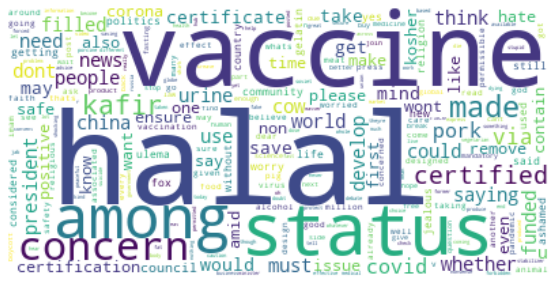

<Figure size 432x288 with 0 Axes>

In [ ]:
tmp3 = []
tmp1 = df.loc[df['Dominant_topic'] == 2]
tmp2 = tmp1['lemmatise'].values.tolist()
for i in tmp2:
  tmp3.extend(i)
fdist = nltk.FreqDist(tmp3)
word_dict = {}
for key in fdist:
    #print ("'%s' occurred %s times" % (key, fdist[key]))
    word_dict[key] = fdist[key]

wordCloud = WordCloud(max_words=500, background_color='white').generate_from_frequencies(word_dict)
plt.figure(figsize=(10,5))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("topic_1.png", dpi=1200)

#Emotion Analysis with NRCLex Detailed Data

In [ ]:
! pip install NRCLex

     |████████████████████████████████| 396 kB 6.7 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=f40888f98c4bb6d79b4ed257f33fb2f5be3202e467756cee82bbc31bf7d0db62
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
from nrclex import NRCLex
from collections import Counter

tmp_nrclex = df
nrclex_emotion = []
i = 0
fear = 0
anger = 0
anticip = 0
trust = 0
surprise = 0
sadness = 0
joy = 0
anticipation = 0
disgust = 0
for index,row in tmp_nrclex.iterrows():
  if row['Dominant_topic'] == 2:
    emotion = NRCLex(row['remove_lower_punct'])
    #print(Counter(emotion.affect_frequencies))
    nrclex_emotion.append(emotion.affect_frequencies)
    i = i + 1
    #print(i)
#print(nrclex_emotion)
for tok in nrclex_emotion:
  fear = tok['fear'] + fear
  anger = tok['anger'] + anger
  anticip = tok['anticip'] + anticip
  trust = tok['trust'] + trust
  surprise = tok['surprise'] + surprise
  sadness = tok['sadness'] + sadness
  joy = tok['joy'] + joy
  try:
    anticipation = tok['anticipation'] + anticipation
  except:
    pass
  disgust = tok['disgust'] + disgust
print(f"Fear {fear}")
print(f"Anger {anger}")
print(f"Anticip {anticip}")
print(f"Trust {trust}")
print(f"Surprise {surprise}")
print(f"Sadness {sadness}")
print(f"Joy {joy}")
print(f"Anticipation {anticipation}")
print(f"Disgust {disgust}")
#total = Counter(nrclex_emotion)
#print(Counter(nrclex_emotion))

Fear 40.257057259905636
Anger 29.695695537916546
Anticip 0.0
Trust 73.49268379953907
Surprise 12.432664030156284
Sadness 33.78733353528211
Joy 29.040971418091488
Anticipation 54.94884211356331
Disgust 23.883576267214025


#LDA Visualization

In [ ]:
from gensim import corpora, models, similarities
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk
from nltk.corpus import stopwords
from operator import itemgetter
import re
import csv
import pprint

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemma_pos = []
for row in df['lemmatise']:
  lemma_pos.extend(row)
id2word = corpora.Dictionary([lemma_pos])
texts = lemma_pos
corpus = [id2word.doc2bow([text]) for text in texts]

n_topics = 4
lda_model = models.LdaModel(corpus=corpus,
                            id2word=id2word,
                            num_topics = n_topics,
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='symmetric',
                            per_word_topics=True)


In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print(arr)

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[[0.62497586 0.12500787 0.12500803 0.12500829]
 [0.12502508 0.12502415 0.62492532 0.12502545]
 [0.62498397 0.12500522 0.12500533 0.12500548]
 ...
 [0.12500095 0.62499714 0.12500094 0.12500097]
 [0.62499899 0.12500033 0.12500034 0.12500036]
 [0.62499994 0.12500003 0.12500003 0.12500003]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 44643 samples in 0.069s...
[t-SNE] Computed neighbors for 44643 samples in 1.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44643
[t-SNE] Computed conditional probabilities for sample 2000 / 44643
[t-SNE] Computed conditional probabilities for sample 3000 / 44643
[t-SNE] Computed conditional probabilities for sample 4000 / 44643
[t-SNE] Computed conditional probabilities for sample 5000 / 44643
[t-SNE] Computed conditional probabilities for sample 6000 / 44643
[t-SNE] Computed conditional probabilities for sample 7000 / 44643
[t-SNE] Computed conditional probabilities for sample 8000 / 44643
[t-SNE] Computed conditional prob